In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime
%matplotlib widget

4.772163552745736
19.287715361448377
12.791846024021321
11.099300745201885
31.928517573244356


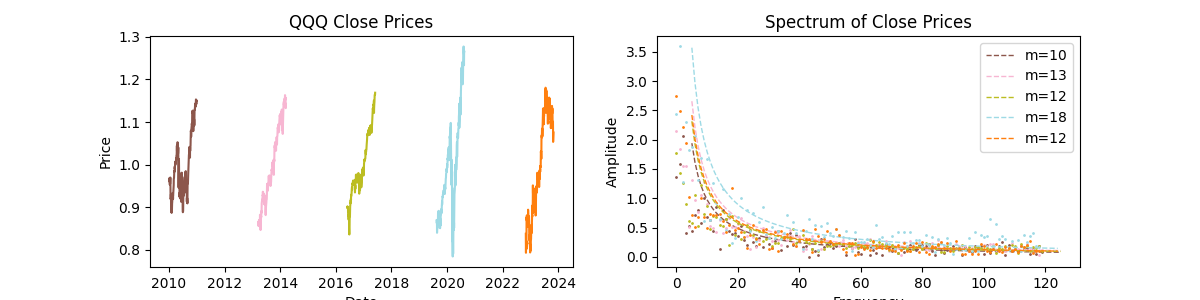

In [11]:
qqq = yf.Ticker("QQQ")

start_dates = pd.date_range(start='2010-01-01', end='2022-11-01', periods=5)

fig, axs = plt.subplots(1, 2, figsize=(12,3))

# axs = [0, axs]

for start_date in start_dates:
    color = plt.cm.tab20(start_date.year % 20)

    start_date = start_date.replace(nanosecond=0)
    end_date = start_date + pd.DateOffset(years=1)

    qqq_data = qqq.history(start=start_date, end=end_date)
    qqq_df = pd.DataFrame(qqq_data)
    close_prices = qqq_df['Close']

    close_prices = close_prices / close_prices.mean()

    axs[0].plot(close_prices, color=color)
    axs[0].set_title('QQQ Close Prices')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Price')

    spectrum = np.fft.fft(close_prices)
    nyquist_freq = len(spectrum) // 2

    phase = np.angle(spectrum[1])
    print(np.abs(spectrum[1]) * (phase))


    def inverse_shift(x, m):
        return m/x
    min_freq = 5
    x = np.arange(min_freq, nyquist_freq)
    popt, pcov = curve_fit(inverse_shift, x, np.abs(spectrum[min_freq:nyquist_freq]))
    m = popt[0]
    y = m/x

    axs[1].plot(np.abs(spectrum[6:nyquist_freq]), '.', color=color, markersize=2)
    axs[1].plot(x, y, color=color, linestyle='--', label=f"m={round(m)}", linewidth=1)
    axs[1].legend()
    axs[1].set_title('Spectrum of Close Prices')
    axs[1].set_xlabel('Frequency')
    axs[1].set_ylabel('Amplitude')
    # axs[1].set_xscale('log')
    # axs[1].set_yscale('log')
